# LangGraph HITL (Human in the Loop)
## 뉴스 검색 keyword 가드레일

- **동적 인터럽트 (Dynamic Interrupts)**: 특정 노드 내에서 코드 실행 중 조건에 따라 `interrupt()` 함수를 호출하여 그래프를 일시 중지
- **정적 인터럽트 (Static Interrupts)**: 그래프를 컴파일할 때 `interrupt_before` 또는 `interrupt_after` 인자를 사용하여 특정 노드의 실행 전후에 항상 일시 중지되도록 설정

In [1]:
import uuid
from typing import Annotated, Optional, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages

from dotenv import load_dotenv
from langchain_teddynote.tools import GoogleNews
from langchain_teddynote.graphs import visualize_graph

import gradio as gr

RISKY_KEYWORDS = [
    "자살", "자해", "폭력", "살인", "강간",
    "19금", "성인", "포르노", "야동", "음란"
]

## 도구 및 상태 구성

In [2]:
load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [3]:
google_news= GoogleNews()

@tool
def news_search(query: str) -> str:
    """뉴스 검색 도구를 호출해 결과를 반환한다."""
    results = google_news.search_by_keyword(query, k=5)
    text = "\n".join(
        f"- {r.get('content','(내용없음)')} | {r.get('url','')}" for r in results
    ) or "검색 결과 없음"
    return text


def contains_risky_term(text: str) -> bool:
    """텍스트에 위험/민감 키워드가 포함됐는지 검사한다."""
    text = str(text or "").strip().lower()
    return any(k in text for k in (kw.lower() for kw in RISKY_KEYWORDS))

@tool
def keyword_guardrail(query: str) -> str:
    """
    질의에 위험/민감 키워드가 포함됐는지 검사하고, 포함 시 사람에게 승인을 구하기 위해 실행을 중단한다.
    - 위험어 포함: interrupt(...)로 일시 중단 → 재개 후 'APPROVED' 또는 'DENIED' 반환
    - 미포함: 'SAFE' 반환
    """
    if contains_risky_term(query):
        resume_payload = interrupt({"query": query})
        user_decision = str(resume_payload.get("data", "")).strip().lower()
        if user_decision in {"예", "yes"}:
            return "APPROVED"
        return "DENIED"
    return "SAFE"

tools = [keyword_guardrail, news_search]
llm_with_tools = llm.bind_tools(tools)

## 상태 정의

In [4]:
# 상태 타입 정의: total=False로 선택적 필드 지정
class AgentState(TypedDict, total=False):
    messages: Annotated[list, "LLM 메시지 목록", add_messages]
    result: Annotated[Optional[str], "keyword_guardrail 응답 내용",]


## 그래프 노드 정의

In [8]:
SYSTEM_PROMPT = (
    "당신은 뉴스 검색 어시스턴트입니다. "
    "먼저 사용자의 질문에 대해 항상 'keyword_guardrail' 도구를 사용해야 합니다. "
    "그 결과가 'SAFE' 또는 'APPROVED'이면, 원래 사용자 질문을 가지고 'news_search' 도구를 사용해야 합니다. "
    "뉴스 검색 결과를 받은 후에는, 그 내용을 요약하여 사용자에게 최종 답변을 제공하세요. "
    "만약 'DENIED'라면, 안전 상의 이유로 검색 결과를 제공하지 않는다고 알리세요."
)

def ensure_system_once(msgs: list[BaseMessage]) -> list[BaseMessage]:
    # SystemMessage가 계속 누적되는 것을 방지
    if not msgs or not isinstance(msgs[0], SystemMessage):
        return [SystemMessage(content=SYSTEM_PROMPT)] + msgs
    return msgs

# --- Nodes ---
def agent_node(state: AgentState) -> AgentState:
    """LLM에 상태의 메시지들을 전달하고 응답을 받아 상태에 추가"""
    messages = ensure_system_once(state.get("messages", []))
    ai = llm_with_tools.invoke(messages)
    return {"messages": [ai]}

def guardrail_extractor(state: AgentState) -> AgentState:
    """keyword_guardrail 도구 결과를 추출하여 state['result']에 저장"""
    for msg in reversed(state.get("messages", [])):
        # ToolNode 실행 후 도구 응답은 ToolMessage(name=<tool_name>) 형태
        if isinstance(msg, ToolMessage) and msg.name == "keyword_guardrail":
            return {"result": msg.content}  # 'SAFE' / 'APPROVED' / 'DENIED'
    return {}


## 그래프 구성 및 컴파일

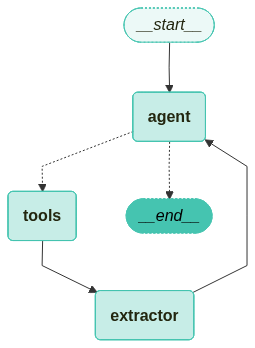

In [9]:

graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)
graph.add_node("tools", ToolNode(tools))
graph.add_node("extractor", guardrail_extractor)

graph.add_edge(START, "agent")
graph.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",   # tool_calls 있으면 ToolNode로
        "__end__": END,     # 없으면 종료
    },
)
graph.add_edge("tools", "extractor")
graph.add_edge("extractor", "agent")


# 인터럽트 세이브포인트용 메모리
checkpointer = InMemorySaver()
app = graph.compile(checkpointer=checkpointer)

visualize_graph(app)

## UI 구성

### 입출력 처리 함수

In [10]:
def _last_ai_text(state: dict) -> str:
    """상태의 마지막 AI 메시지 내용을 반환한다."""
    msgs = state.get("messages", [])
    for m in reversed(msgs):
        if isinstance(m, AIMessage):
            return str(m.content or "")
    return ""

def submit_query(user_input, cfg_state, chat_history, pending_flag):
    """사용자 입력 처리"""
    if not user_input.strip():
        return chat_history, cfg_state, gr.update(interactive=False), gr.update(interactive=False), pending_flag

    cfg = {"configurable": {"thread_id": str(uuid.uuid4())}}
    chat_history = chat_history + [{"role": "user", "content": user_input}]

    try:
        result_state = app.invoke({"messages": [HumanMessage(content=user_input)]}, config=cfg)
    except Exception as e:
        chat_history += [{"role": "assistant", "content": f"⚠️ 오류 발생: {e}"}]
        return chat_history, cfg, gr.update(interactive=False), gr.update(interactive=False), False

    if contains_risky_term(user_input):
        # 인터럽트 발생
        chat_history += [{
            "role": "assistant",
            "content": "⚠️ 위험 키워드가 포함되어 있습니다. 계속 진행할까요? '예' 또는 '아니오'를 선택하세요."
        }]
        return chat_history, cfg, gr.update(interactive=True), gr.update(interactive=True), True

    # 안전한 경우 결과 출력
    final_txt = _last_ai_text(result_state) or "결과가 없습니다."
    chat_history += [{"role": "assistant", "content": final_txt}]
    return chat_history, cfg, gr.update(interactive=False), gr.update(interactive=False), False


def resume_yes(cfg_state, chat_history, pending_flag):
    """‘예’ 승인"""
    if not cfg_state or not pending_flag:
        return chat_history, gr.update(interactive=False), gr.update(interactive=False), False
    try:
        result_state = app.invoke(Command(resume={"data": "예"}), config=cfg_state)
        final_txt = _last_ai_text(result_state) or "결과가 없습니다."
        chat_history += [{"role": "assistant", "content": final_txt}]
    except Exception as e:
        chat_history += [{"role": "assistant", "content": f"⚠️ 재개 중 오류: {e}"}]
    return chat_history, gr.update(interactive=False), gr.update(interactive=False), False


def resume_no(cfg_state, chat_history, pending_flag):
    """‘아니오’ 거부"""
    if not cfg_state or not pending_flag:
        return chat_history, gr.update(interactive=False), gr.update(interactive=False), False
    try:
        result_state = app.invoke(Command(resume={"data": "아니오"}), config=cfg_state)
        final_txt = _last_ai_text(result_state) or "검색 결과를 제공하지 않습니다."
        chat_history += [{"role": "assistant", "content": final_txt}]
    except Exception as e:
        chat_history += [{"role": "assistant", "content": f"⚠️ 재개 중 오류: {e}"}]
    return chat_history, gr.update(interactive=False), gr.update(interactive=False), False


### UI 구성

In [11]:
with gr.Blocks(title="LangGraph HITL Guardrail") as demo:
    gr.Markdown("### 🧩 LangGraph HITL (뉴스 검색 가드레일) — 동적 인터럽트 데모")

    # ✅ type="messages" 적용
    chatbot = gr.Chatbot(type="messages", height=400)
    user_input = gr.Textbox(label="검색어를 입력하세요", placeholder="예: 최신 AI 뉴스를 검색해줘")
    with gr.Row():
        btn_submit = gr.Button("질문 보내기", variant="primary")
        btn_yes = gr.Button("예(승인)", interactive=False)
        btn_no = gr.Button("아니오(거부)", interactive=False)

    st_cfg = gr.State(value=None)
    st_pending = gr.State(value=False)
    st_chat = gr.State(value=[])

    # 이벤트 연결
    btn_submit.click(
        submit_query,
        inputs=[user_input, st_cfg, st_chat, st_pending],
        outputs=[chatbot, st_cfg, btn_yes, btn_no, st_pending]
    )

    btn_yes.click(
        resume_yes,
        inputs=[st_cfg, chatbot, st_pending],
        outputs=[chatbot, btn_yes, btn_no, st_pending]
    )

    btn_no.click(
        resume_no,
        inputs=[st_cfg, chatbot, st_pending],
        outputs=[chatbot, btn_yes, btn_no, st_pending]
    )

    user_input.submit(
        submit_query,
        inputs=[user_input, st_cfg, st_chat, st_pending],
        outputs=[chatbot, st_cfg, btn_yes, btn_no, st_pending]
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [ ]:
demo.close()

-----
** End of Documents **